In [2]:
import astropy.units as u
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from astropy.table import QTable, Row

import adetsim.sim_src.AttenuationData as ad
from adetsim.sim_src.FlareSpectrum import FlareSpectrum
from adetsim.sim_src.DetectorStack import DetectorStack
from adetsim.sim_src.Material import Material
from adetsim.hafx_src.Sipm3000 import Sipm3000

import plotting
plotting.apply_style('spectrum_paper')

In [3]:
TABLE_PICKLE = './atmospheric-attenuation/mcmurdo-station/atmosphere-composition.pkl'
with open(TABLE_PICKLE, 'rb') as infile:
    ATMOSPHERIC_LOOKUP_TABLE = pickle.load(infile)

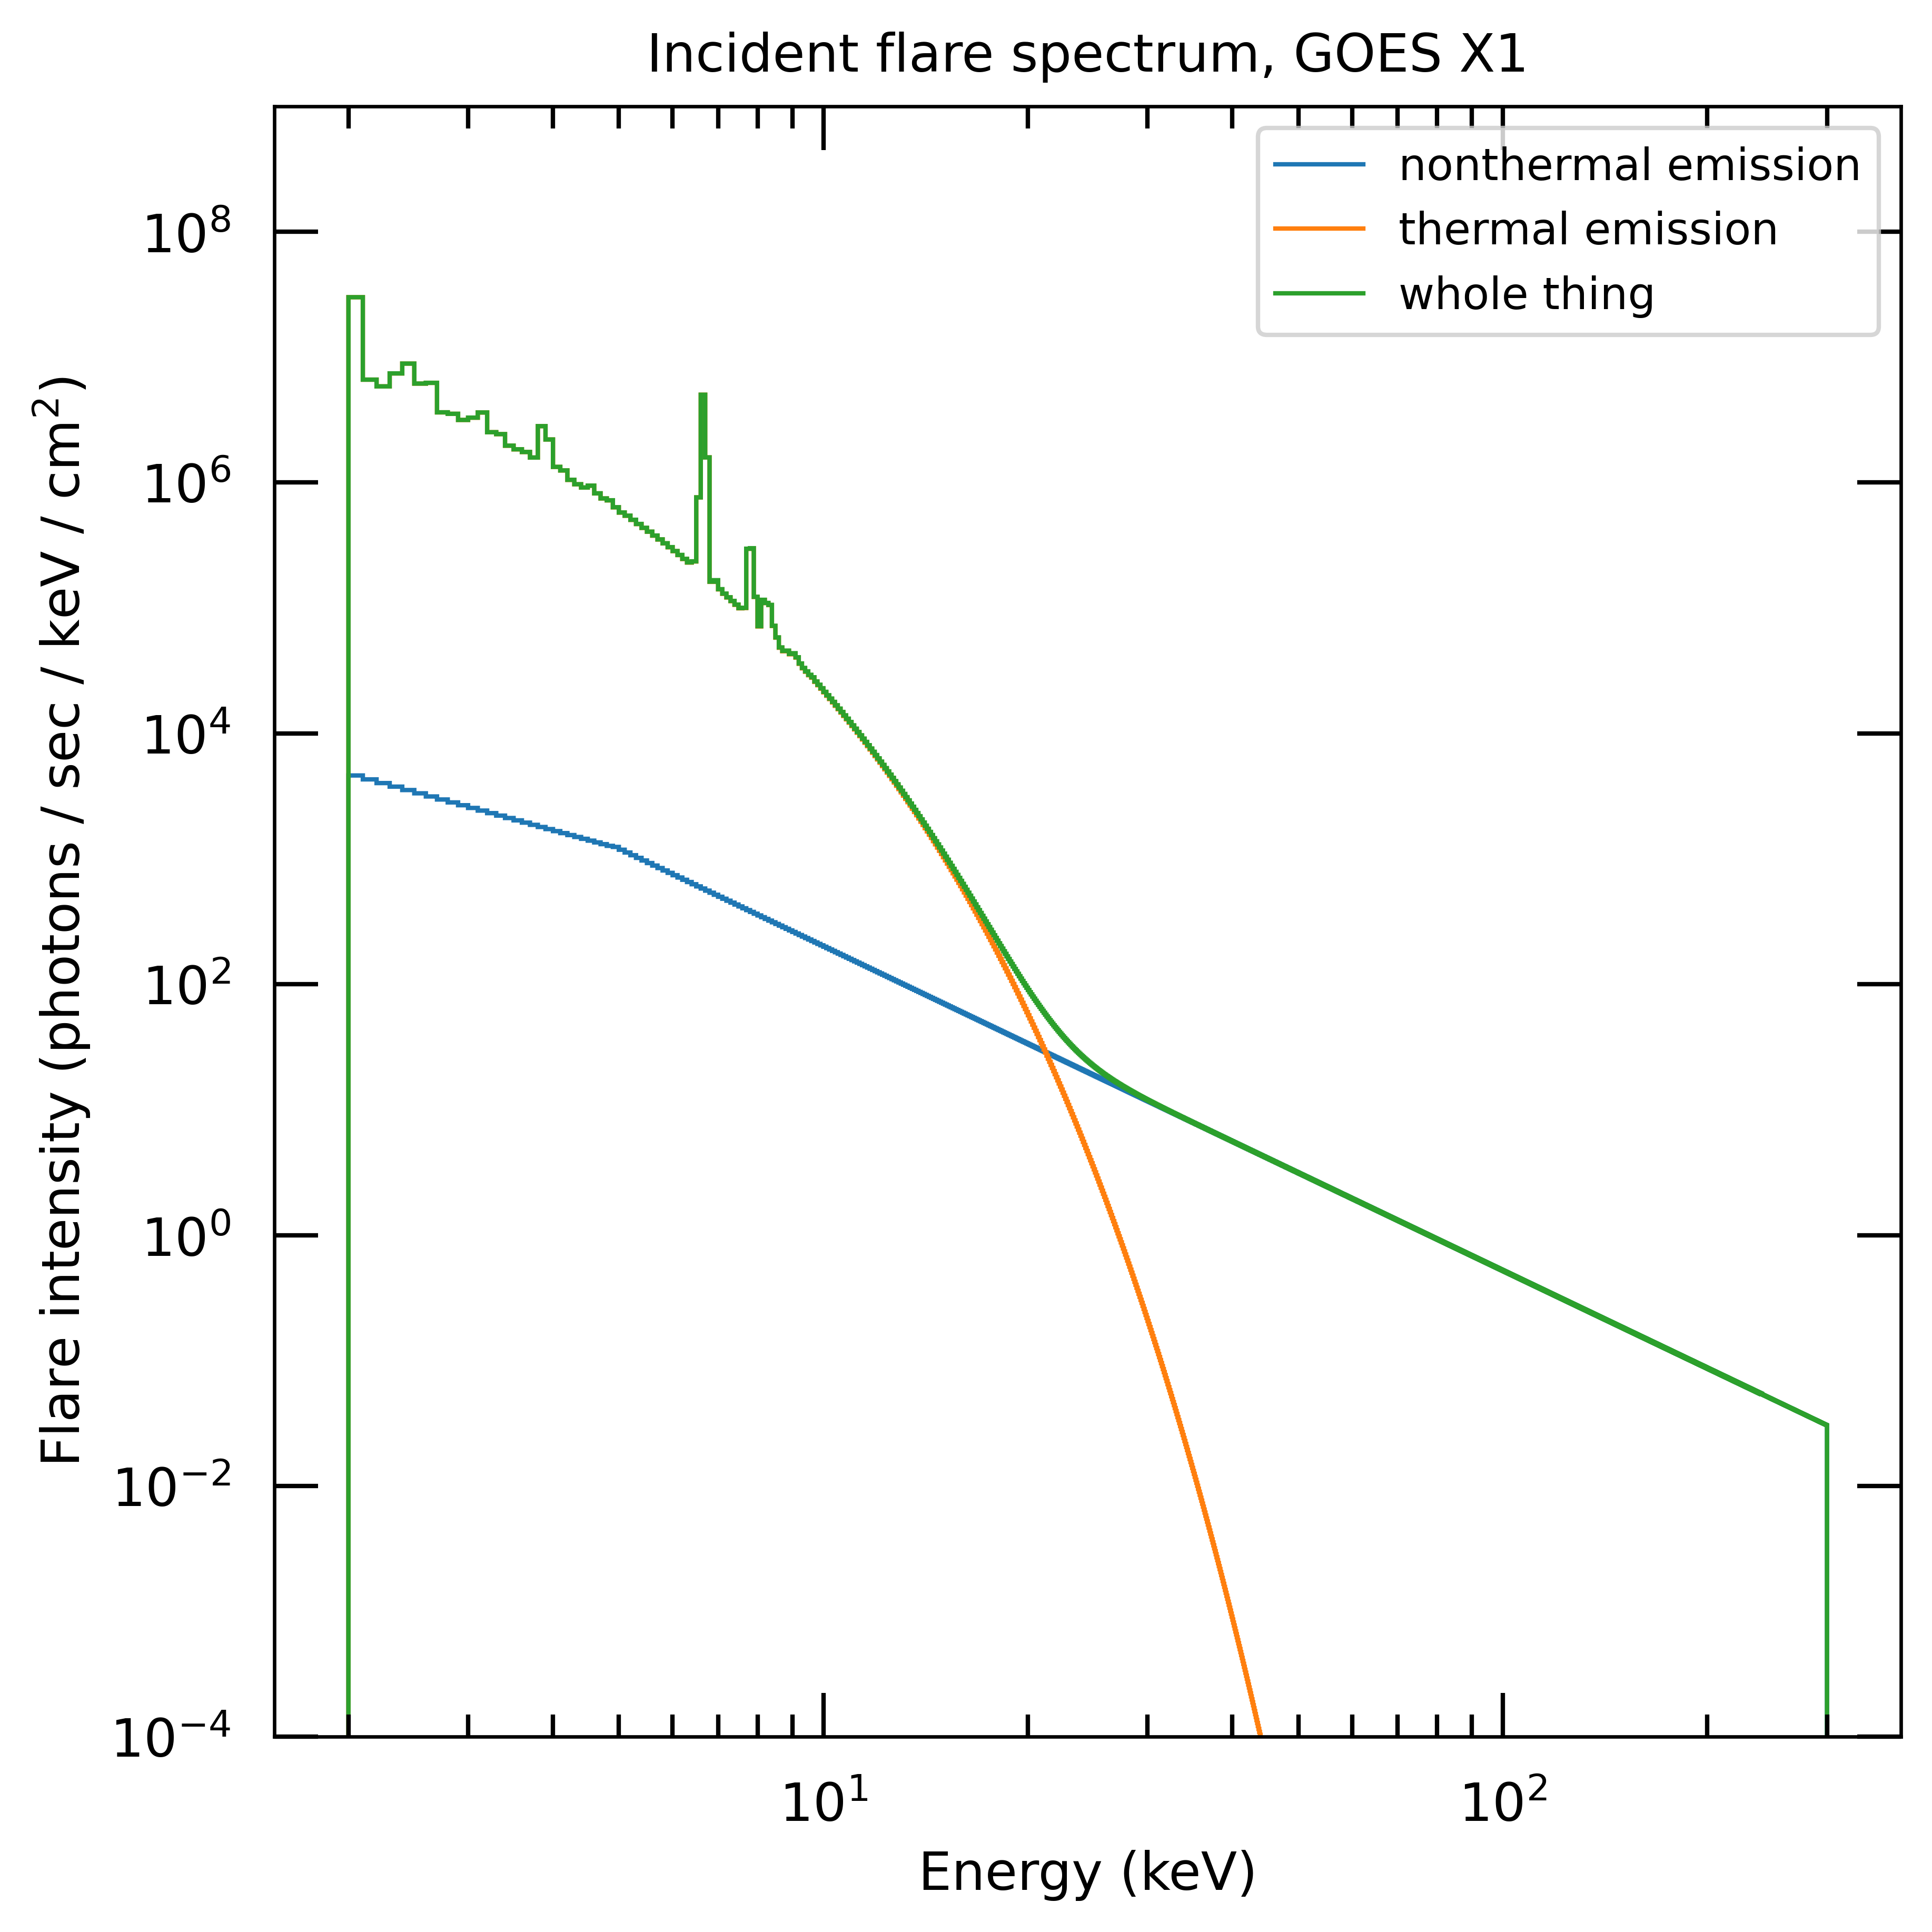

In [15]:
def generate_flare_spectrum(goes_class: str = 'X9') -> FlareSpectrum:

    start, end = 2, 300 # keV
    delta_e = 0.1 # keV
    edges = np.arange(start, end + delta_e, delta_e)

    fs = FlareSpectrum.make_with_battaglia_scaling(
        goes_class=goes_class, 
        energy_edges=edges
    )

    fig, ax = plt.subplots(figsize=(6,6), layout='constrained')

    ax.stairs(fs.nonthermal, fs.energy_edges, label='nonthermal emission')
    ax.stairs(fs.thermal, fs.energy_edges, label='thermal emission')
    ax.stairs(fs.flare, fs.energy_edges, label='whole thing')

    ax.set(
        xlabel='Energy (keV)',
        ylabel='Flare intensity (photons / sec / keV / cm${}^2$)',
        title = f'Incident flare spectrum, GOES {goes_class}',
        xscale='log',
        yscale='log',
        ylim=(1e-4, 1e9)
    )
    ax.legend()
    # plt.savefig(os.path.join('flare-spectrum.png'), dpi=120)
    plt.show()

    return fs

flare_spectrum = generate_flare_spectrum()

In [5]:
def _get_altitude_row(altitude: u.Quantity) -> Row:
    """
    Helper function to retrieve data for a specific altitude.
    If the specified altitude is not in the table, this function
    returns the data for the altitude closest to that specified.
    """

    diffs = np.abs(ATMOSPHERIC_LOOKUP_TABLE['Heit'] - altitude)
    index = np.where(diffs == diffs.min())[0][0]
    
    return ATMOSPHERIC_LOOKUP_TABLE[index]


def _generate_layer_composition(row: Row) -> dict[str, float]:
    """
    Computes the **elemental** abundances for the provided row.

    If there is a corresponding molecular form for the element
    (e.g. oxygen), then the composition accounts for the two
    oxygen atoms per molcule when computing the new abundances.
    """
    
    abund_cols = ['Oabund','N2abund', 'O2abund', 'Heabund', 'Arabund', 'Habund', 'Nabund']
    abundances = row[abund_cols]

    composition = {}
    for element in abundances.colnames:
        element_name = element.replace('abund', '')
        
        if element_name[-1].isnumeric():
            multiplier = int(element_name[-1])
            element_name = element_name[:-1]
        else:
            multiplier = 1
        
        if element_name in composition:
            composition[element_name] += multiplier * row[element]
        else:
            composition[element_name] = multiplier * row[element]

    total = np.sum(list(composition.values()))
    normalized_composition = {}
    for element, abundance in composition.items():
        normalized_composition[element] = abundance / total

    return normalized_composition


def generate_atmospheric_layer_material(altitude: u.Quantity) -> Material:
    """
    Generates a Material object for the provided altitude.
    """

    altitude = altitude << u.km
    row = _get_altitude_row(altitude)
    rho = row['air'] << u.g / (u.cm**3)
    thickness = np.diff(ATMOSPHERIC_LOOKUP_TABLE['Heit'])[0] << u.cm

    elemental_abundances = _generate_layer_composition(row)
    layer_attenuation = ad.AttenuationData.from_compound_dict(elemental_abundances)
    layer = Material(10, thickness.value, rho.value, layer_attenuation, name=f'atmosphere{row["Heit"].value}{row["Heit"].unit}')

    return layer


def attenuate_spectrum_through_layer(
    spectrum: FlareSpectrum,
    altitude: u.Quantity,
    apply_energy_resolution: bool = False
) -> FlareSpectrum:

    material = generate_atmospheric_layer_material(altitude)
    detector = DetectorStack([material], Sipm3000())
    atmospheric_response = detector.generate_detector_response_to(spectrum, disperse_energy=apply_energy_resolution)
    spectrum_after_attenuation = atmospheric_response @ spectrum.flare

    return spectrum_after_attenuation


def attenuate_spectrum_through_layers(
    spectrum: FlareSpectrum,
    start_altitude: u.Quantity,
    stop_altitude: u.Quantity,
    step: u.Quantity,
    apply_energy_resolution: bool = False
) -> FlareSpectrum:
    """
    This works but it prevents us from being able to examine the spectrum at each layer.
    """

    layers = []
    for altitude in np.arange(start_altitude.value, stop_altitude.value-step.value, -1 * step.value):
        print(altitude)
        layers.append(generate_atmospheric_layer_material(altitude*step.unit))
    detector = DetectorStack(layers, Sipm3000())
    atmospheric_response = detector.generate_detector_response_to(spectrum, disperse_energy=apply_energy_resolution)
    spectrum_after_attenuation = atmospheric_response @ spectrum.flare

    return spectrum_after_attenuation


def plot_spectrum(spectrum: FlareSpectrum, ax: plt.Axes = None, **kwargs) -> plt.Axes:

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6), layout='constrained')

    ax.stairs(spectrum.flare, spectrum.energy_edges, **kwargs)
    ax.set(
        xlabel='Energy (keV)',
        ylabel='ct / keV / sec / cm2',
        title = 'Atmospheric attenuation',
        xscale='log',
        yscale='log',
        ylim=(1e-6, 1e9)
    )
    ax.legend()

    return ax


# altitude = 1 * u.km
# material = generate_atmospheric_layer_material(altitude)
# detector = DetectorStack([material], Sipm3000())

## Iterate through specified altitudes

In [17]:
input_spectrum = copy.deepcopy(flare_spectrum)
out_spectrum = attenuate_spectrum_through_layers(
    input_spectrum,
    start_altitude=100*u.km,
    stop_altitude=40*u.km,
    step=np.diff(ATMOSPHERIC_LOOKUP_TABLE['Heit'])[0]
)

100.0
95.0
90.0
85.0
80.0
75.0
70.0
65.0
60.0
55.0
50.0
45.0
40.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Atmospheric attenuation'}, xlabel='Energy (keV)', ylabel='ct / keV / sec / cm2'>

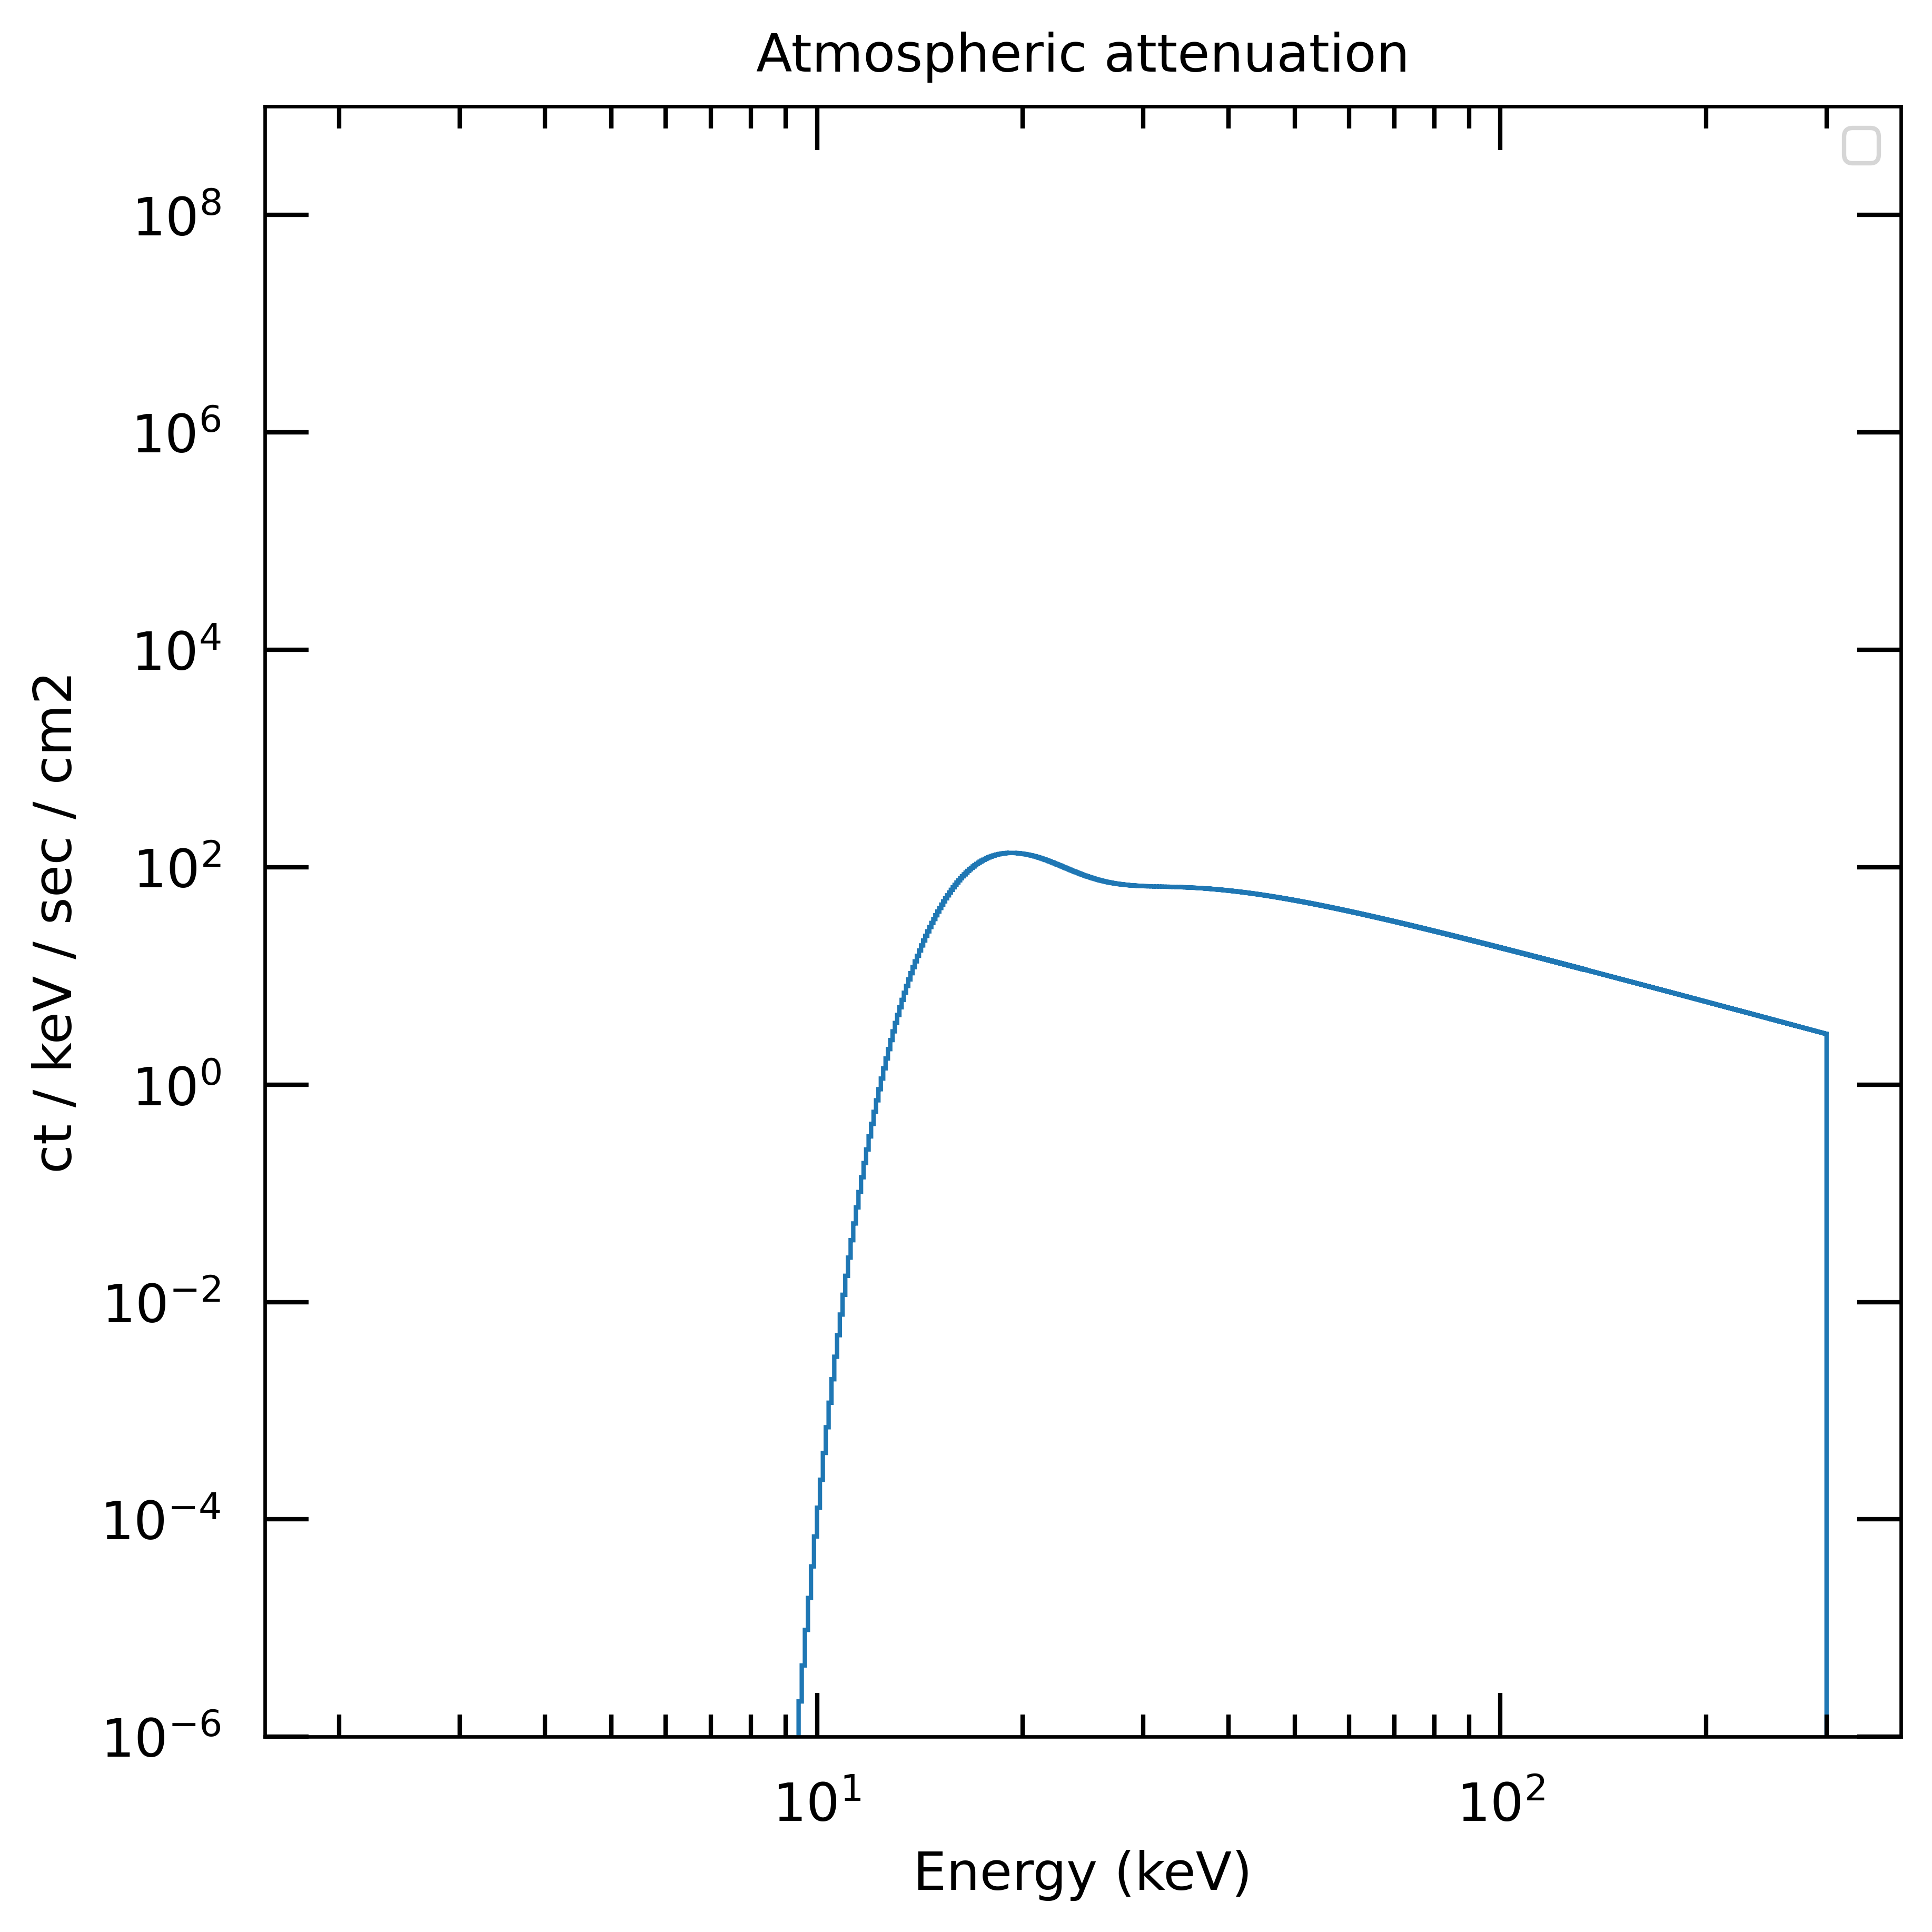

In [19]:
layer_spectrum = FlareSpectrum(
    goes_class=input_spectrum.goes_class,
    energy_edges=input_spectrum.energy_edges,
    thermal=out_spectrum, # technically wrong, but it'll work
    nonthermal=np.zeros(shape=out_spectrum.shape)
)
plot_spectrum(layer_spectrum)

In [20]:
from astropy.constants import e

output_spectrum = layer_spectrum
dist = output_spectrum.flare * u.ph/u.s/(u.cm**2)/u.keV
edges = output_spectrum.energy_edges * u.keV
optical_gain = 25 * u.ct / u.ph / u.keV

plate_xray_cps = dist * np.diff(edges) * (4*u.cm)**2

print(plate_xray_cps)
print('total x-ray photons:', np.sum(plate_xray_cps))

plate_optical_cps = plate_xray_cps * optical_gain * (edges[:-1] + np.diff(edges))
total_opticals = np.sum(plate_optical_cps)
print('total optical photons:', total_opticals)

total_current = total_opticals * (3e6*u.electron / u.ct) * (e.si / u.electron) << u.microampere
print('total current:', total_current)

print(total_opticals/np.sum(plate_xray_cps))

# print(np.sum(layer_spectrum.flare * np.diff(layer_spectrum.energy_edges)) * u.ct/u.s/(u.cm**2))

[0.         0.         0.         ... 4.67949712 4.67686471 4.67423465] ph / s
total x-ray photons: 89378.40853343389 ph / s
total optical photons: 171734428.18537185 ct / s
total current: 82.54466642758614 uA
1921.430813137951 ct / ph


In [6]:
start = 100 * u.km # ATMOSPHERIC_LOOKUP_TABLE['Heit'].max()
stop = 30 * u.km
current_altitude = start
step = np.diff(ATMOSPHERIC_LOOKUP_TABLE['Heit'])[0]
out_dir = f'./atmospheric-attenuation/mcmurdo-model-data/{flare_spectrum.goes_class}-layer-attenuation/'
os.makedirs(out_dir, exist_ok=True)
print(f'Iterating from {start} to {stop} altitude at {step} steps')

input_spectrum = copy.deepcopy(flare_spectrum)
while current_altitude >= stop:

    print(input_spectrum.flare)
    print('Processing altitude', current_altitude)
    layer_flare = attenuate_spectrum_through_layer(input_spectrum, current_altitude)
    layer_spectrum = FlareSpectrum(
        goes_class=input_spectrum.goes_class,
        energy_edges=input_spectrum.energy_edges,
        thermal=layer_flare, # technically wrong, but it'll work
        nonthermal=np.zeros(shape=layer_flare.shape)
    )

    ax = plot_spectrum(input_spectrum, color='blue', label='layer incident spectrum')
    plot_spectrum(layer_spectrum, ax=ax, color='black', label='layer output spectrum')
    plot_file = os.path.join(out_dir, f'{current_altitude.value}{current_altitude.unit}.png')
    pickle_file = plot_file.replace('.png', '.pkl')
    plt.savefig(plot_file, dpi=150)
    with open(pickle_file, 'wb') as outfile:
        pickle.dump(layer_spectrum, outfile)
    
    current_altitude -= step
    input_spectrum = copy.deepcopy(layer_spectrum)

NameError: name 'flare_spectrum' is not defined

## Plot specific altitude

Text(0.5, 1.0, 'X9-class spectrum seen at 40 km')

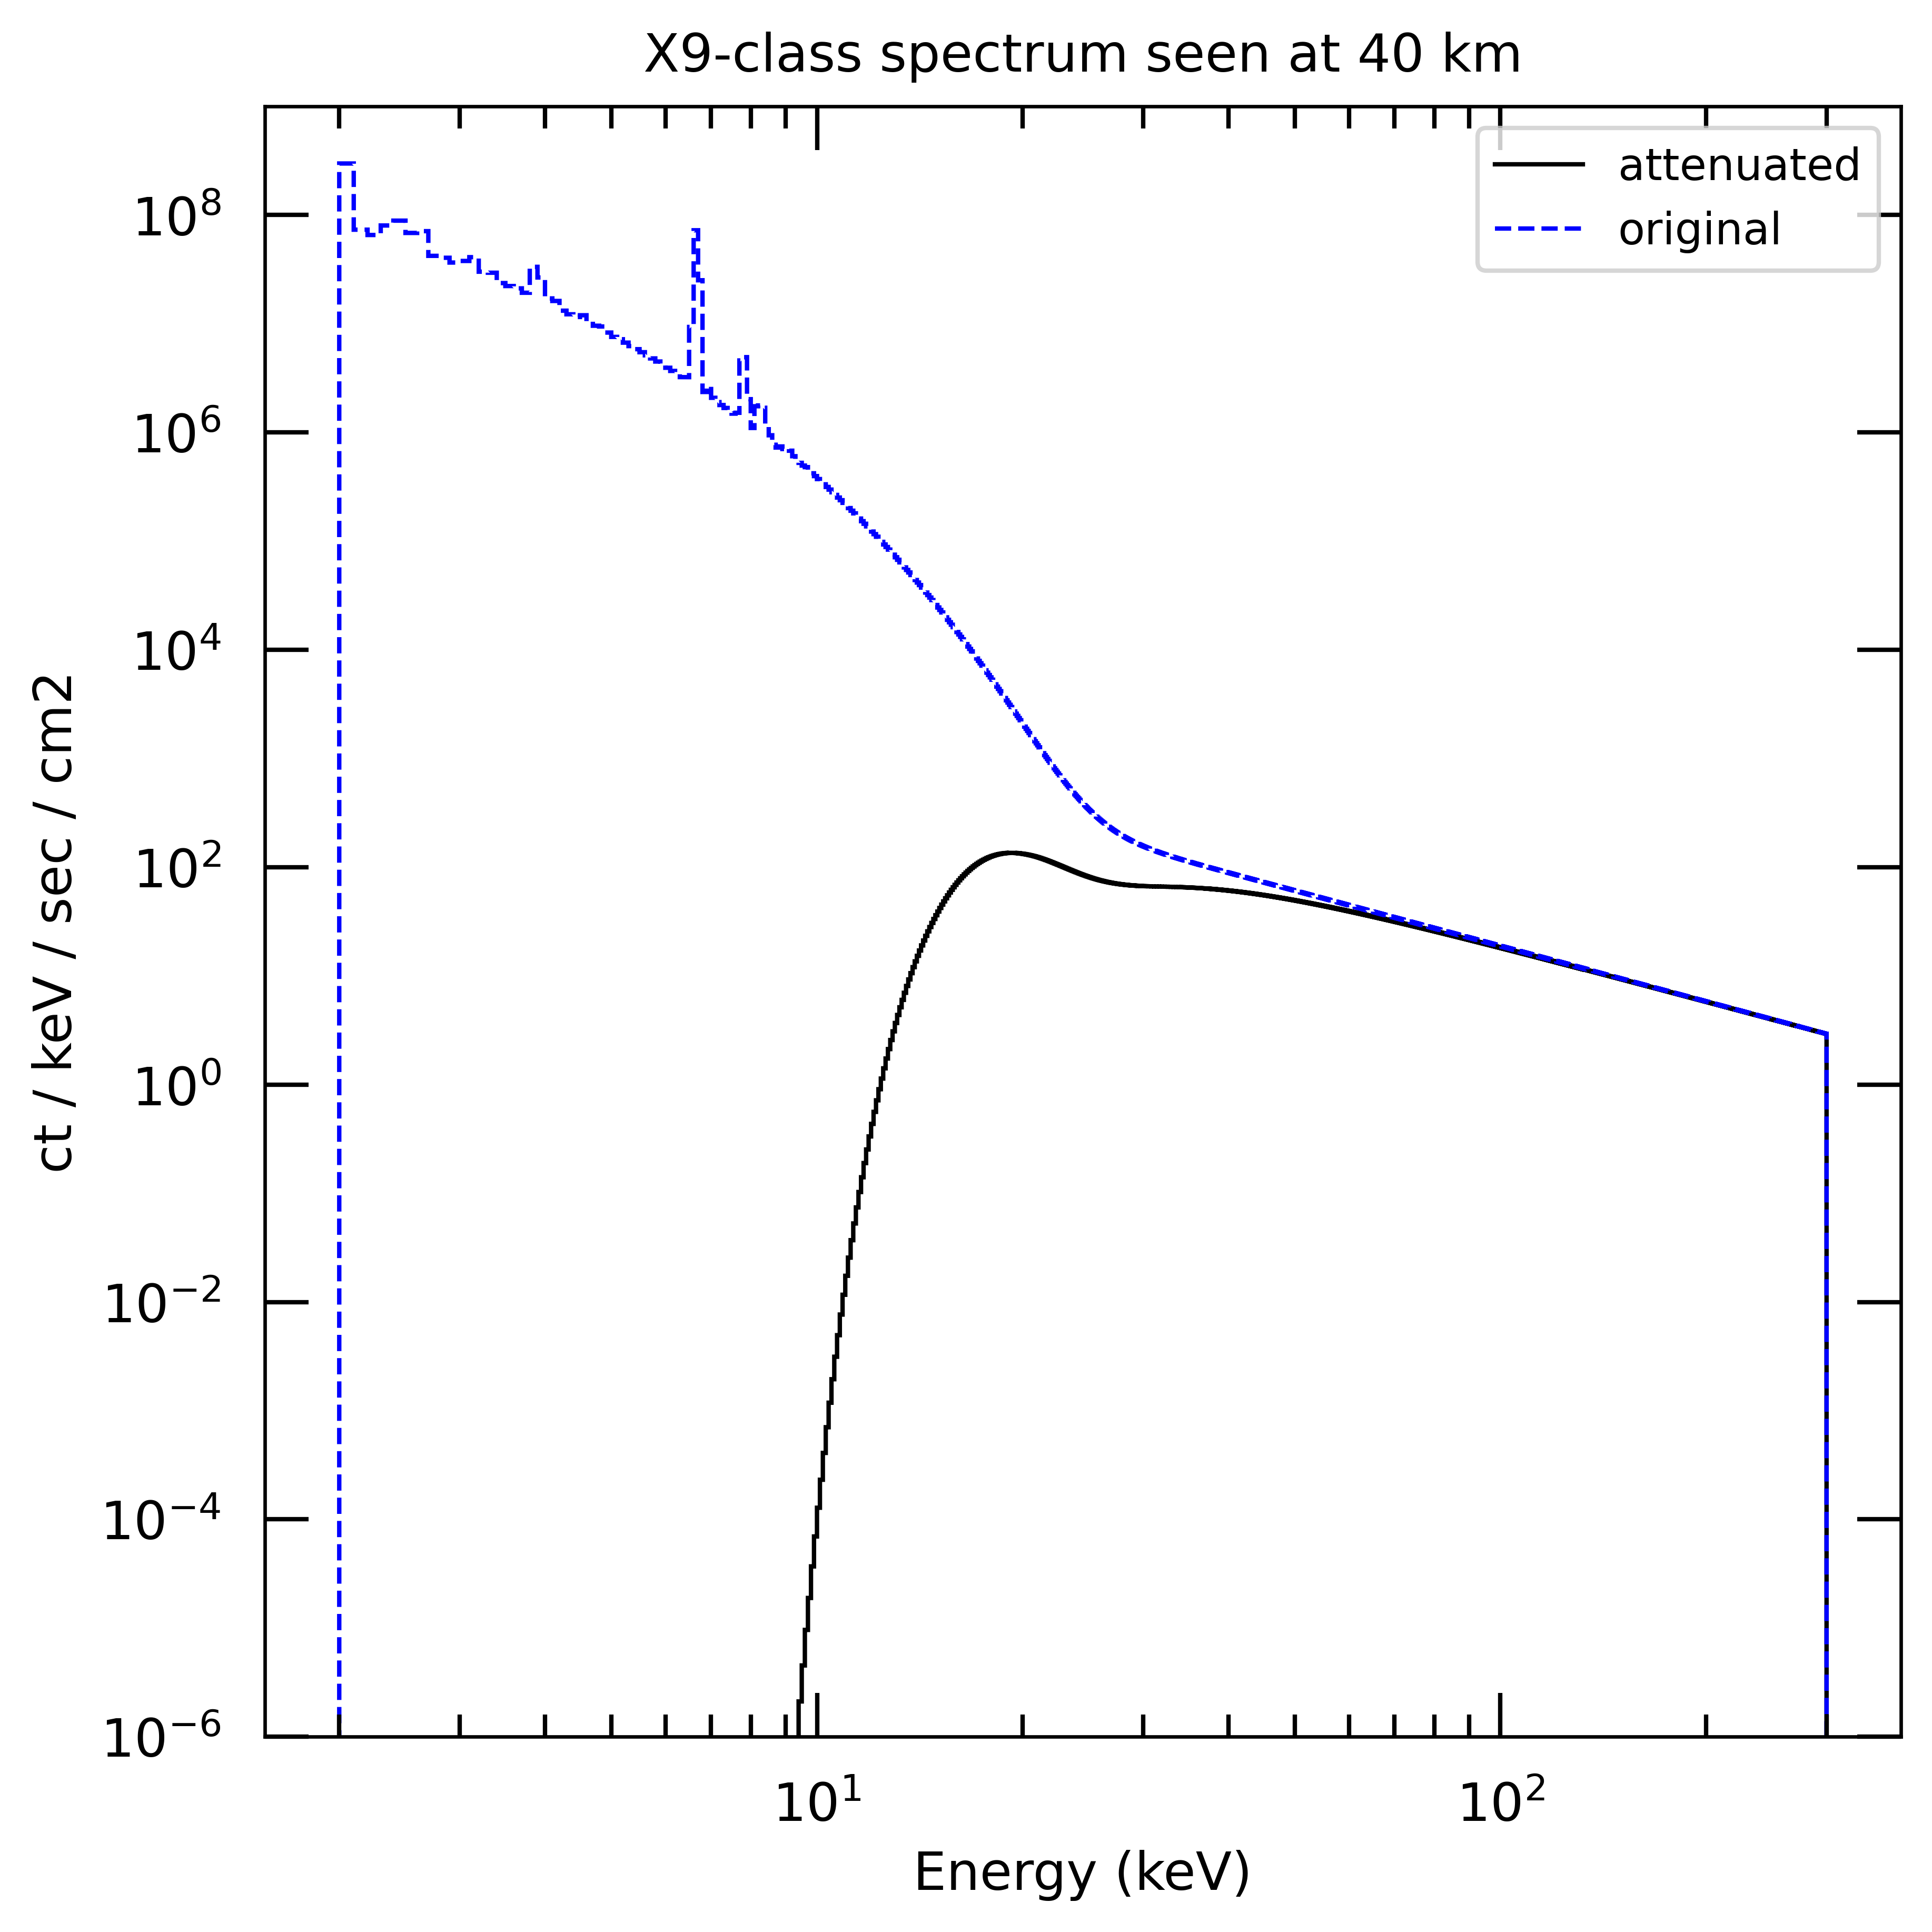

In [9]:
pickle_file = '/home/reed/Documents/research/grimpress/cubesat-analytical-detector-sim/atmospheric-attenuation/mcmurdo-station/X9-layer-attenuation/40.0km.pkl'
with open(pickle_file, 'rb') as infile:
    spectrum_40km = pickle.load(infile)


ax = plot_spectrum(spectrum_40km, color='black', label='attenuated')
plot_spectrum(flare_spectrum, ax=ax, color='blue', ls='--', label='original')
ax.set_title('X9-class spectrum seen at 40 km')

## Compute photon stats

In [16]:
from astropy.constants import e

# output_spectrum = spectrum_40km
output_spectrum = flare_spectrum
dist = output_spectrum.flare * u.ph/u.s/(u.cm**2)/u.keV
edges = output_spectrum.energy_edges * u.keV
optical_gain = 25 * u.ct / u.ph / u.keV

plate_xray_cps = dist * np.diff(edges) * (4*u.cm)**2

print(plate_xray_cps)
print('total x-ray photons:', np.sum(plate_xray_cps))

plate_optical_cps = plate_xray_cps * optical_gain * (edges[:-1] + np.diff(edges))
total_opticals = np.sum(plate_optical_cps)
print('total optical photons:', total_opticals)

total_current = total_opticals * (3e6*u.electron / u.ct) * (e.si / u.electron) << u.microampere
print('total current:', total_current)

print(total_opticals/np.sum(plate_xray_cps))

# print(np.sum(layer_spectrum.flare * np.diff(layer_spectrum.energy_edges)) * u.ct/u.s/(u.cm**2))

[4.80052997e+07 1.05703069e+07 9.34505790e+06 ... 4.88450260e-02
 4.88029008e-02 4.87608259e-02] ph / s
total x-ray photons: 209564055.81853342 ph / s
total optical photons: 17125513799.203276 ct / s
total current: 8231.429416298415 uA
81.7197096721237 ct / ph


In [7]:
# apply_energy_resolution = False
# atmospheric_response = detector.generate_detector_response_to(spectrum, disperse_energy=apply_energy_resolution)
# flare_after_thick = atmospheric_response @ spectrum.flare

# fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')
# ax.stairs(spectrum.flare, spectrum.energy_edges, label='Original flare')
# ax.stairs(flare_after_thick, spectrum.energy_edges, label='After atmospheric attenuation')

# ax.set(
#     xlabel='Energy (keV)',
#     ylabel='(photons or counts) / keV / sec / cm2',
#     title = 'atmospheric response',
#     xscale='log',
#     yscale='log',
#     ylim=(1e-6, 1e9)
# )
# ax.legend()
# plt.show()